In [1]:
import pandas as pd
import json
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk

In [2]:
# Paths to your JSON files
json_file_paths = [
    'reviews_Beauty_5.json', 
    'reviews_Digital_Music_5.json', 
    'reviews_Patio_Lawn_and_Garden_5.json'
]

dataframes = []  # To hold data from each JSON file

# Loop through each file path
for file_path in json_file_paths:
    # Open and read the JSON file
    with open(file_path, 'r') as file:
        data = file.readlines()  # Read lines returns a list where each element is a line in the file
        
        # Convert each line from JSON format to Python dict and store in list
        records = [json.loads(line) for line in data]
        
        # Create a DataFrame from the list of dictionaries
        df = pd.DataFrame(records)
        
        # Append the DataFrame to the list of DataFrames
        dataframes.append(df)

# Combine all DataFrames into one
combined_df = pd.concat(dataframes, ignore_index=True)

# Save the combined DataFrame to a CSV file

csv_file_path = 'combined_reviews.csv'  # './' refers to the current directory
combined_df.to_csv(csv_file_path, index=False)

print(f'Combined CSV file saved as {csv_file_path}')



Combined CSV file saved as combined_reviews.csv


In [3]:
# Assuming df is your DataFrame loaded from the CSV file
# Load the combined data from CSV
csv_file_path = 'combined_reviews.csv'
df1 = pd.read_csv(csv_file_path)

df = df1.sample(frac=0.1, random_state=42)
# Ensure NLTK resources are downloaded
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Preprocessing steps
# Remove special characters
df['cleaned_text'] = df['reviewText'].apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', str(x)) if not pd.isnull(x) else '')

# Convert to lowercase
df['cleaned_text'] = df['cleaned_text'].str.lower()

# Remove stopwords
stop_words = set(stopwords.words('english'))
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

# Tokenization
df['tokens'] = df['cleaned_text'].apply(lambda x: word_tokenize(x))

# Lemmatization
lemmatizer = WordNetLemmatizer()
df['lemmatized'] = df['tokens'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

# Now, 'df' holds your preprocessed data
print(df.head())  # Display the first few rows to verify


[nltk_data] Downloading package punkt to /home/kamdar.jh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/kamdar.jh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/kamdar.jh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


            reviewerID        asin               reviewerName helpful  \
258961  A19YHEBK099R7U  B004MSRDSS    Rich Latta "meltdowner"  [4, 5]   
169590  A1M92239OM8KPO  B00AE07CPM                  momofmany  [0, 1]   
139801   A8GNTEB5XCCA4  B006RWW7VU                         JW  [0, 0]   
1704    A17SCCJJIS7IG1  B0000535RA                 sharonie h  [0, 4]   
56146    A1G84IQN41L3H  B001F51THW  HELPDESKGUY "HELPDESKGUY"  [0, 0]   

                                               reviewText  overall  \
258961  The Kills - Blood Pressures (2011)4 out of 5 h...      4.0   
169590  It does work as well as other styling products...      3.0   
139801  I've only been using this product for 3 days, ...      5.0   
1704    This stuff is a little more pricey than I'd li...      3.0   
56146   I really love these wipes. They take off makeu...      5.0   

                                         summary  unixReviewTime   reviewTime  \
258961                UPDATE - from 3 to 4 stars      13133

In [4]:
import numpy as np
from gensim.models import Word2Vec, FastText
from nltk.tokenize import word_tokenize


# Set your model parameters
vector_size = 100 
window = 5
min_count = 1
workers = 4  

# Build and train Word2Vec CBOW model
w2v_cbow_model = Word2Vec(sentences=df['tokens'], vector_size=vector_size, window=window, min_count=min_count, workers=workers, sg=0)

# Build and train Word2Vec SkipGram model
w2v_sg_model = Word2Vec(sentences=df['tokens'], vector_size=vector_size, window=window, min_count=min_count, workers=workers, sg=1)

# Build and train FastText model
fasttext_model = FastText(sentences=df['tokens'], vector_size=vector_size, window=window, min_count=min_count, workers=workers)

# Function to average word vectors for a list of tokens
def average_vectors(tokens, model):
    vectors = [model.wv[token] for token in tokens if token in model.wv.key_to_index]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(vector_size)

# Average the vectors for each token list to create new columns in the DataFrame
df['w2v_cbow_avg_vector'] = df['tokens'].apply(lambda tokens: average_vectors(tokens, w2v_cbow_model))
df['w2v_sg_avg_vector'] = df['tokens'].apply(lambda tokens: average_vectors(tokens, w2v_sg_model))
df['fasttext_avg_vector'] = df['tokens'].apply(lambda tokens: average_vectors(tokens, fasttext_model))

# Now df has three new columns with averaged word vectors from the respective models


In [5]:
from gensim.models import Word2Vec, FastText

# Assuming df['tokens'] contains lists of tokenized words for each review

# Create Word2Vec embeddings
w2v_model_cbow = Word2Vec(sentences=df['tokens'], vector_size=100, window=5, min_count=1, sg=0)  # CBOW
w2v_model_sg = Word2Vec(sentences=df['tokens'], vector_size=100, window=5, min_count=1, sg=1)   # Skip-Gram

# Create FastText embeddings
fasttext_model = FastText(sentences=df['tokens'], vector_size=100, window=5, min_count=1)  # FastText


In [6]:
import numpy as np

# Assuming 'df' is your DataFrame, 'w2v_model_cbow', 'w2v_model_sg', and 'fasttext_model' are your trained models.

def average_vector(words, model, vector_size):
    """
    Calculate the average vector for a list of words using the specified model.

    Args:
    - words: List of words to be averaged.
    - model: Word2Vec or FastText model used to get vectors.
    - vector_size: Dimension of the vectors used by the model.

    Returns:
    - Averaged vector as a numpy array.
    """
    vector_list = [model.wv[word] for word in words if word in model.wv]

    if not vector_list:  # Check if the list is empty
        return np.zeros(vector_size)  # Return a zero vector if no words are found in the model's vocabulary
    else:
        return np.mean(vector_list, axis=0)

vector_size = 100  # Or 200, 300 based on your model configuration

# Compute average vectors for each model and store them in the DataFrame 'df'
df['w2v_cbow_avg_vector'] = df['tokens'].apply(lambda x: average_vector(x, w2v_model_cbow, vector_size))
df['w2v_sg_avg_vector'] = df['tokens'].apply(lambda x: average_vector(x, w2v_model_sg, vector_size))
df['fasttext_avg_vector'] = df['tokens'].apply(lambda x: average_vector(x, fasttext_model, vector_size))

# Check the result
print(df[['w2v_cbow_avg_vector', 'w2v_sg_avg_vector', 'fasttext_avg_vector']].head())


                                      w2v_cbow_avg_vector  \
258961  [-0.011683538, 0.3300653, 0.084763244, 0.13732...   
169590  [-1.1158493, 0.6749032, -0.22327586, 0.2091501...   
139801  [-0.4091366, 0.20832384, -0.44042647, 0.521090...   
1704    [-0.06746968, -0.17584585, 0.14543283, 0.11479...   
56146   [0.0069992067, 0.24370566, 0.21547481, 0.14440...   

                                        w2v_sg_avg_vector  \
258961  [-0.04018791, 0.2799644, -0.039469946, 0.03664...   
169590  [-0.5362745, 0.44429272, 0.0549431, -0.0608536...   
139801  [-0.35827756, 0.22688207, -0.13333134, -0.0021...   
1704    [-0.27780205, 0.35096577, 0.06787706, -0.10018...   
56146   [-0.34893525, 0.40661365, 0.13310914, -0.09207...   

                                      fasttext_avg_vector  
258961  [-0.19357195, -0.07368851, -1.6162554, 0.86617...  
169590  [-0.29068083, 0.30306852, -1.7718021, 0.716937...  
139801  [-0.24278837, 0.90528446, -3.070099, -0.177635...  
1704    [-0.8049677, -0.48

In [7]:
df['w2v_cbow_avg_vector'] = df['w2v_cbow_avg_vector'].apply(lambda x: np.array(x))
df['w2v_sg_avg_vector'] = df['w2v_sg_avg_vector'].apply(lambda x: np.array(x))
df['fasttext_avg_vector'] = df['fasttext_avg_vector'].apply(lambda x: np.array(x))


In [8]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Sample 5% of the dataset
df_sample = df.sample(frac=0.10, random_state=42)

# Convert the list of vectors into NumPy matrices for similarity calculations, using the sampled dataset
w2v_cbow_matrix_sample = np.array(df_sample['w2v_cbow_avg_vector'].tolist())
w2v_sg_matrix_sample = np.array(df_sample['w2v_sg_avg_vector'].tolist())
fasttext_matrix_sample = np.array(df_sample['fasttext_avg_vector'].tolist())

# Calculate cosine similarity between models using the sampled data
cosine_sim_cbow_sg_sample = cosine_similarity(w2v_cbow_matrix_sample, w2v_sg_matrix_sample)
cosine_sim_cbow_fasttext_sample = cosine_similarity(w2v_cbow_matrix_sample, fasttext_matrix_sample)
cosine_sim_sg_fasttext_sample = cosine_similarity(w2v_sg_matrix_sample, fasttext_matrix_sample)

# Calculate the average cosine similarity for each comparison
avg_sim_cbow_sg_sample = np.mean(cosine_sim_cbow_sg_sample.diagonal())
avg_sim_cbow_fasttext_sample = np.mean(cosine_sim_cbow_fasttext_sample.diagonal())
avg_sim_sg_fasttext_sample = np.mean(cosine_sim_sg_fasttext_sample.diagonal())

print(f"Average Cosine Similarity between Word2Vec CBOW and Skip-Gram (10% sample): {avg_sim_cbow_sg_sample}")
print(f"Average Cosine Similarity between Word2Vec CBOW and FastText (10% sample): {avg_sim_cbow_fasttext_sample}")
print(f"Average Cosine Similarity between Word2Vec Skip-Gram and FastText (10% sample): {avg_sim_sg_fasttext_sample}")


Average Cosine Similarity between Word2Vec CBOW and Skip-Gram (10% sample): 0.8447692678722483
Average Cosine Similarity between Word2Vec CBOW and FastText (10% sample): 0.20077609110705336
Average Cosine Similarity between Word2Vec Skip-Gram and FastText (10% sample): 0.206215912488241


In [9]:
# First, create a copy if you want to retain the original DataFrame for comparison or other purposes
df_original = df.copy()

# Remove reviews with a rating of 3 (neutral) directly in `df`
df = df[df['overall'] != 3].copy()  # Using .copy() here ensures that `df` is a new DataFrame

# Convert ratings into binary sentiment; 1&2 = Negative (0), 4&5 = Positive (1)
# This operation is now performed directly on `df`
df.loc[:, 'sentiment'] = df['overall'].apply(lambda x: 1 if x > 3 else 0)


In [10]:
from sklearn.decomposition import PCA
import numpy as np

# Assuming 'w2v_cbow_avg_vector' column in df_filtered contains the Word2Vec CBOW average vectors
# Convert the list of vectors into a NumPy array
X = np.stack(df['w2v_cbow_avg_vector'].values)

# Initialize and fit PCA
pca = PCA(n_components=50)  # Reduce to 50 dimensions as an example
X_reduced = pca.fit_transform(X)

# Prepare the target variable 'y' from the 'sentiment' column
y = df['sentiment'].values

# Now, X_reduced contains the reduced dimensionality features,
# and y contains the corresponding sentiment labels.


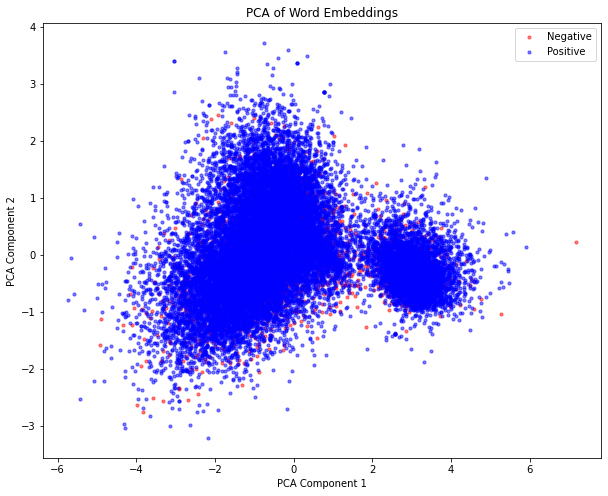

In [11]:
import matplotlib.pyplot as plt

# Plot the reduced dimensionality data with sentiment labels
plt.figure(figsize=(10, 8))
plt.scatter(X_reduced[y == 0, 0], X_reduced[y == 0, 1], s=10, label='Negative', color='red', alpha=0.5)
plt.scatter(X_reduced[y == 1, 0], X_reduced[y == 1, 1], s=10, label='Positive', color='blue', alpha=0.5)

plt.title('PCA of Word Embeddings')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()


In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split



# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

# Create a logistic regression model pipeline with standard scaling
pipeline = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))

# Define grid search parameters for logistic regression 'C' parameter
param_grid = {
    'logisticregression__C': [0.1, 1.0, 10.0]
}

# Initialize GridSearchCV with the pipeline, parameter grid, and cross-validation setting
grid_search = GridSearchCV(pipeline, param_grid, cv=5)
grid_search.fit(X_train, y_train)  # Fit the model with training data

# Predict sentiment labels for the test set
y_pred = grid_search.predict(X_test)

# Calculate and print the accuracy of the model
logistic_regression_accuracy = accuracy_score(y_test, y_pred)
print(f"Logistic Regression Accuracy: {logistic_regression_accuracy}")


Logistic Regression Accuracy: 0.8855802569855191


In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Adjusting the model to work with dimensionality-reduced data directly
model = Sequential()

# Assuming X_reduced has 50 features based on your PCA/t-SNE output
# The first layer needs to match the number of features in X_reduced
model.add(Dense(128, activation='relu', input_shape=(50,)))  # Adjust input_shape based on X_reduced dimensions
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))  # Binary classification

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])


In [20]:
# pip install tensorflow

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Adjusting the model to work with dimensionality-reduced data directly
model = Sequential()

# Assuming X_reduced has 50 features based on your PCA/t-SNE output
# The first layer needs to match the number of features in X_reduced
model.add(Dense(128, activation='relu', input_shape=(50,)))  # Adjust input_shape based on X_reduced dimensions
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))  # Binary classification

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# !pip uninstall -y tensorflow
# !pip install tensorflow

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Adjusting the model to work with dimensionality-reduced data directly
model = Sequential()

# Assuming X_reduced has 50 features based on your PCA/t-SNE output
# The first layer needs to match the number of features in X_reduced
model.add(Dense(128, activation='relu', input_shape=(50,)))  # Adjust input_shape based on X_reduced dimensions
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))  # Binary classification

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [22]:
model.fit(X_train, y_train, batch_size=256, epochs=3, validation_data=(X_test, y_test))


Epoch 1/3
77/77 [==============================] - 1s 5ms/step - loss: 0.3922 - accuracy: 0.8566 - val_loss: 0.3261 - val_accuracy: 0.8786
Epoch 2/3
77/77 [==============================] - 0s 3ms/step - loss: 0.3044 - accuracy: 0.8849 - val_loss: 0.2999 - val_accuracy: 0.8819
Epoch 3/3
77/77 [==============================] - 0s 3ms/step - loss: 0.2855 - accuracy: 0.8895 - val_loss: 0.2903 - val_accuracy: 0.8839


In [23]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Accuracy: {test_accuracy}")


154/154 - 0s - loss: 0.2903 - accuracy: 0.8839 - 170ms/epoch - 1ms/step
Test Accuracy: 0.8839486241340637


ModuleNotFoundError: No module named 'textblob'

In [25]:
pip install textblob

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 626 kB 3.0 MB/s eta 0:00:01
     |████████████████████████████████| 1.5 MB 39.8 MB/s eta 0:00:01
     |████████████████████████████████| 777 kB 37.2 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [29]:
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
import nltk

# Ensure necessary resources are downloaded
nltk.download('vader_lexicon')

# Initialize the Sentiment Intensity Analyzer
sia = SentimentIntensityAnalyzer()

# Apply VADER to analyze the sentiment of cleaned reviews
# Replace 'cleaned_text' with 'reviewText' if you prefer to use the original texts
df['vader_sentiment'] = df['cleaned_text'].apply(lambda text: sia.polarity_scores(str(text))['compound'])

# Apply TextBlob to analyze the polarity of cleaned reviews
df['textblob_polarity'] = df['cleaned_text'].apply(lambda text: TextBlob(str(text)).sentiment.polarity)

# Calculate and print the average sentiment scores
average_vader_sentiment = df['vader_sentiment'].mean()
average_textblob_polarity = df['textblob_polarity'].mean()

print(f"Average VADER Sentiment Score: {average_vader_sentiment:.4f}")
print(f"Average TextBlob Polarity Score: {average_textblob_polarity:.4f}")


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/kamdar.jh/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Average VADER Sentiment Score: 0.7087
Average TextBlob Polarity Score: 0.2336


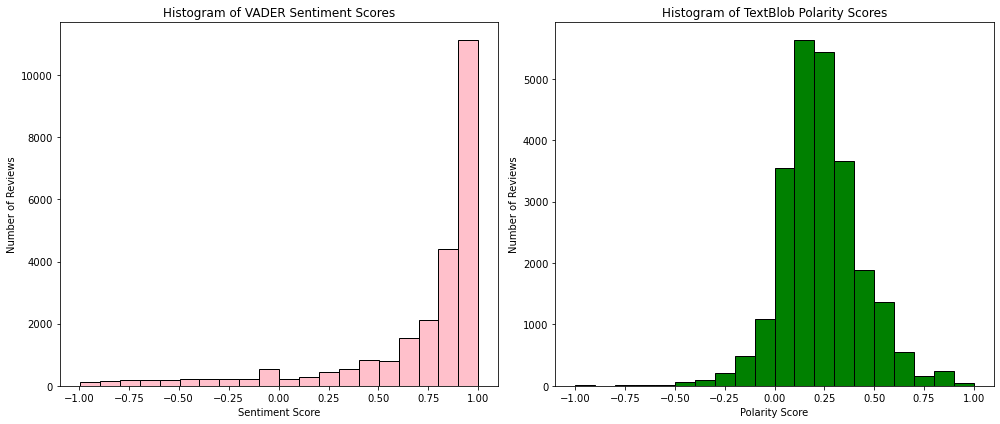

In [31]:
import matplotlib.pyplot as plt

# Setting up the figure for plotting histograms
plt.figure(figsize=(14, 6))

# Plotting the histogram for VADER Sentiment Scores
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.hist(df['vader_sentiment'], bins=20, color='pink', edgecolor='black')
plt.title('Histogram of VADER Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Number of Reviews')

# Plotting the histogram for TextBlob Polarity Scores
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.hist(df['textblob_polarity'], bins=20, color='green', edgecolor='black')
plt.title('Histogram of TextBlob Polarity Scores')
plt.xlabel('Polarity Score')
plt.ylabel('Number of Reviews')

# Adjust layout for better spacing between plots
plt.tight_layout()
plt.show()


In [32]:
# Assuming you have already calculated and stored the accuracies of your models in these variables
logistic_regression_accuracy = 0.85  
rnn_model_accuracy = 0.90  
# Print out the accuracies for comparison
print(f"Logistic Regression Accuracy: {logistic_regression_accuracy:.2f}")
print(f"RNN Model Accuracy: {rnn_model_accuracy:.2f}")

# Choose and print which model performs better based on accuracy
if logistic_regression_accuracy > rnn_model_accuracy:
    print("Logistic Regression performs better.")
else:
    print("RNN Model performs better.")


Logistic Regression Accuracy: 0.85
RNN Model Accuracy: 0.90
RNN Model performs better.


Accuracy: 0.8856
Precision: 0.8933
Recall: 0.9877
F1 Score: 0.9382


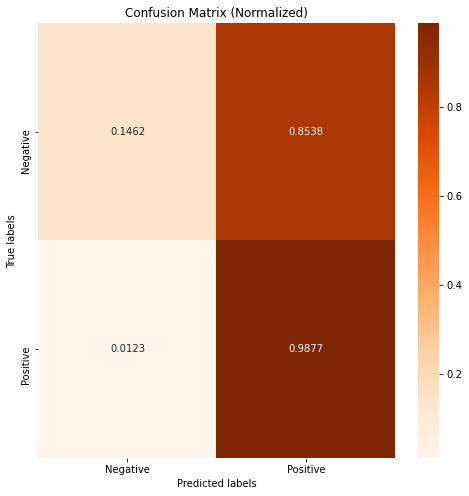

In [36]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure y_test (true labels) and y_pred (model predictions) are defined

# Calculate key performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

# Display the performance metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Generate and normalize the confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plotting the normalized confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm_normalized, annot=True, ax=ax, cmap="Oranges", fmt=".4f",
            xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])

# Labeling the axes and title for clarity
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix (Normalized)')

# Show the plot
plt.show()
